In [96]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
%matplotlib inline

In [97]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [98]:
# Read in data
data = Path("tsla_cleansed.csv")
stock_df = pd.read_csv(data)
#df.sort_values("date")
stock_df.head()

,date,compound,negative,neutral,positive,text,Prices
0,2012-05-23,0.9972,0.067,0.737,0.197,In today s bubble 2 0 world billions of VC do...,0.007470
1,2012-06-21,0.6808,0.067,0.836,0.097,EquitiesAsian markets gained on Wednesday ahe...,-0.048239
2,2012-08-05,0.9971,0.034,0.822,0.144,Entrepreneurs that have the capacity to change...,NaN
3,2012-10-19,0.9898,0.069,0.781,0.150,Google Inc GOOG got caught naked yesterday ...,-0.010734
4,2012-11-19,0.9893,0.006,0.917,0.077,Recent Performance of the Stocks Mentioned Bel...,0.031387


In [99]:
stock_df = stock_df.drop(columns=["text"])

In [100]:
stock_df.dropna(inplace=True)

In [101]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [102]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 5
target_column = 5
X, y = window_data(stock_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:4]} \n")
print (f"y sample values:\n{y[:4]}")

X sample values:
[[ 0.00746996 -0.04823912 -0.01073428  0.03138732  0.03359253]
 [-0.04823912 -0.01073428  0.03138732  0.03359253 -0.04794326]
 [-0.01073428  0.03138732  0.03359253 -0.04794326 -0.00582573]
 [ 0.03138732  0.03359253 -0.04794326 -0.00582573 -0.02165605]] 

y sample values:
[[-0.04794326]
 [-0.00582573]
 [-0.02165605]
 [-0.00992619]]


In [103]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [104]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [105]:
y_test

array([[0.37233552],
       [0.37233552],
       [0.36151506],
       ...,
       [0.62940015],
       [0.62940015],
       [0.62940015]])

In [106]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.38071768]
  [0.23592354]
  [0.33340282]
  [0.44288158]
  [0.44861318]]

 [[0.23592354]
  [0.33340282]
  [0.44288158]
  [0.44861318]
  [0.23669252]]

 [[0.33340282]
  [0.44288158]
  [0.44861318]
  [0.23669252]
  [0.34616069]]

 [[0.44288158]
  [0.44861318]
  [0.23669252]
  [0.34616069]
  [0.30501592]]

 [[0.44861318]
  [0.23669252]
  [0.34616069]
  [0.30501592]
  [0.33550314]]] 

X_test sample values:
[[[0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]]

 [[0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]]

 [[0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]]

 [[0.37233552]
  [0.37233552]
  [0.37233552]
  [0.37233552]
  [0.36151506]]

 [[0.37233552]
  [0.37233552]
  [0.37233552]
  [0.36151506]
  [0.36151506]]]


In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [108]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [109]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [110]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_14 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [111]:
X_train = X_train.astype("float32")
X_train

array([[[0.38071766],
        [0.23592354],
        [0.3334028 ],
        [0.44288158],
        [0.44861317]],

       [[0.23592354],
        [0.3334028 ],
        [0.44288158],
        [0.44861317],
        [0.23669252]],

       [[0.3334028 ],
        [0.44288158],
        [0.44861317],
        [0.23669252],
        [0.34616068]],

       ...,

       [[0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552]],

       [[0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552]],

       [[0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552],
        [0.37233552]]], dtype=float32)

In [112]:
y_train = y_train.astype('float32')
y_train

array([[0.23669252],
       [0.34616068],
       [0.30501592],
       ...,
       [0.37233552],
       [0.37233552],
       [0.37233552]], dtype=float32)

In [113]:
# Train the model
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=1, verbose=1)

Epoch 1/20
2739/2739 [==============================] - 18s 5ms/step - loss: 0.0231
Epoch 2/20
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0093
Epoch 3/20
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0081
Epoch 4/20
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0075
Epoch 5/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0069
Epoch 6/20
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0069
Epoch 7/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0064
Epoch 8/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0065
Epoch 9/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0067
Epoch 10/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0065
Epoch 11/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.0063
Epoch 12/20
2739/2739 [==============================] - 12s 4ms/step - lo

In [114]:
# Save model as JSON
model_json = model.to_json()

file_path = Path("model_2.json")
with open(file_path, "w") as json_file:
    json_file.write(model_json)

# Save weights
file_path = "model_2.h5"
model.save_weights("model_2.h5")

In [115]:
# Evaluate the model
model.evaluate(X_test, y_test)

37/37 [==============================] - 1s 2ms/step - loss: 0.0032


0.0032434025779366493

In [116]:
# Make some predictions
predicted = model.predict(X_test)

In [117]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [118]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = stock_df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
2982,0.004245,0.003956
2983,0.004245,0.003956
2984,0.000082,0.003956
2985,0.000082,0.000460
2986,0.027732,0.000721


In [119]:
stocks.head(200)

,Real,Predicted
2982,0.004245,0.003956
2983,0.004245,0.003956
2984,0.000082,0.003956
2985,0.000082,0.000460
2986,0.027732,0.000721
...,...,...
3204,0.003634,0.002152
3205,0.003634,0.002355
3206,0.003634,0.002622
3207,0.003634,0.003307


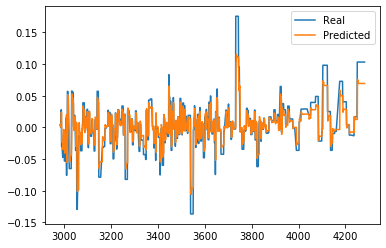

In [120]:
# Plot the real vs predicted prices as a line chart
stocks.plot()